# 1. Field Shaping Algorithm in JAX

The rotating magnetic setup consists of two identical rotating magnets with a certain distance between them. This  setup experiences magnetic field gradients parallel to the magnets when simple block magnets are used. These gradients generate unwanted forces, preventing the system from operating purely based on magnetic torque. While weaker magnets and minimizing the distance between opposing magnets can reduce these gradients, small residual gradients will persist.    

Several approaches can be used to further lower the magnetic gradient, including modifying magnetization strength, adjusting geometric properties, or changing the distance between opposing magnets. Among these, adjusting the distance between the opposing magnets is the most practical option, as it can be easily achieved by using multiple small magnets and 3D-printed slots to control their spacing. In contrast, altering geometric or magnetic properties is more challenging due to the limited availability of magnet shapes and the complexity of manufacturing custom magnet geometries.    

This notebook calculates the optimal magnetic setup for a specified magnetic field strength with the smallest possible gradient parallel to the magnets. This ensures that the rotating magnetic setup operates purely with torque without creating any unwanted gradients parallel to the magnets.

We rely on JAX, an advanced library from Google that combines just-in-time (JIT) compilation, automatic differentiation (autograd), and Accelerated Linear Algebra (XLA) for high-performance computing in Python. By JIT compiling numerical routines, JAX converts Python functions into optimized machine code, substantially speeding up repeated integrals over large magnet grids. Its autograd feature allows gradient-based optimization, making it easy to fine-tune magnet spacing for minimal residual gradients. Meanwhile, XLA provides hardware-specific optimizations to run computations efficiently on CPUs, GPUs, or TPUs. Together, these capabilities ensure our rotating magnetic setup can be rapidly evaluated and adjusted to achieve stable torque without unwanted forces.

In [1]:
import numpy as np
import time
import jax
import jax.numpy as jnp
import numpy.polynomial.legendre as lg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

TOL = 1e-5  # Tolerance for numerical integration

In [2]:
#------------------------------------------------------------------
# Dimensions and coordinates of the magnet grid, magnets and observation points.
#------------------------------------------------------------------
A_TOTAL = 80e-3    # Grid width (x-dimension)   
A_ONE   = 0.8e-3   # Magnet width (x-dimension)   
N_X     = 100      # Number of magnets in x-direction   
B_TOTAL = 18e-3    # Grid depth (y-dimension)   
B_ONE   = 1e-3     # Magnet depth (y-dimension)   
N_Y     = 18       # Number of magnets in y-direction   
H       = 5e-3     # Magnet height (z-dimension)    
MZ      = 1.19     # Magnetization along z

# Vertical offsets for each magnet column (using same offset for all)
ZL = jnp.full(N_X, 20e-3)

# Observation points (only one coordinate can be an array; the others must be zero)
X_VAL = 0.0  # Change this to set the variable coordinate.
Y_VAL = 0.0 
Z_VAL = jnp.arange(-19e-3, 19.1e-3, 1e-4)   


In [124]:
#------------------------------------------------------------------
# 1. Setup: Contains functions that handle configuration, precomputation, and integration setup.
#------------------------------------------------------------------

    #------------------------------------------------------------------
    # 1.1 compute_centers: Computes the centers of the magnets.
    #------------------------------------------------------------------
def compute_centers(a_total, a_one, n_x, b_total, b_one, n_y):
    x_centers = jnp.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = jnp.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    return x_centers, y_centers

    #------------------------------------------------------------------
    # 1.2 Setup_Integration: Compute integration bounds and broadcast obeservation points.
    # The function derives integration bounds (X_MINS, X_MAXS, Y_MINS, Y_MAXS)for each magnet. 
    # It broadcasts the observation coordinates into arrays and flattens them into 1D arrays, 
    # so that vectorized operations (using JAX’s vmap) can efficiently compute the field.
    #------------------------------------------------------------------
@jax.jit
def setup_integration():
    # Compute magnet centers and integration bounds.
    XCENTERS, YCENTERS = compute_centers(A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y)
    X_MINS = XCENTERS - A_ONE / 2.0
    X_MAXS = XCENTERS + A_ONE / 2.0
    Y_MINS = YCENTERS - B_ONE / 2.0
    Y_MAXS = YCENTERS + B_ONE / 2.0
    
    # Broadcast observation points (only one coordinate is an array).
    x_arr, y_arr, z_arr = jnp.broadcast_arrays(jnp.atleast_1d(X_VAL),
                                              jnp.atleast_1d(Y_VAL),
                                              jnp.atleast_1d(Z_VAL))
    x_flat = jnp.array(x_arr.ravel())
    y_flat = jnp.array(y_arr.ravel())
    z_flat = jnp.array(z_arr.ravel())
    return X_MINS, X_MAXS, Y_MINS, Y_MAXS, x_flat, y_flat, z_flat, x_arr.shape

    #------------------------------------------------------------------
    # 1.3 Precompute_Leggauss: Precompute Gauss–Legendre nodes and weights.
    # Precomputing Gauss–Legendre nodes and weights prevents redundant calculations during repeated numerical integrations,
    # thereby improving performance when using vectorized operations (vmap) in subsequent field computations.
    #------------------------------------------------------------------
def precompute_leggauss(orders):
    nodes_dict = {}
    weights_dict = {}
    for order in orders:
         nodes_np, weights_np = lg.leggauss(order)
         nodes_dict[order] = jnp.array(nodes_np)
         weights_dict[order] = jnp.array(weights_np)
    return nodes_dict, weights_dict

#------------------------------------------------------------------
# 2. Magnetic field: Contains all functions related to the core magnetic field calculations.
#------------------------------------------------------------------

    #------------------------------------------------------------------
    # 2.1 dBz_jax: Inverse cube law for the z-field from a point dipole.
    #------------------------------------------------------------------
@jax.jit
def dBz_jax(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx * sx + sy * sy + sz * sz
    return sz / (jnp.sqrt(s) * s)

    #------------------------------------------------------------------
    # 2.2 gauss2d_jax: 2D Gauss–Legendre quadrature over a rectangular area.
    #------------------------------------------------------------------
def gauss2d_jax(func, a, b, c, d, nodes, weights, x_param, y_param, z_param):
    half_b_a = 0.5 * (b - a)
    mid_b_a  = 0.5 * (b + a)
    half_d_c = 0.5 * (d - c)
    mid_d_c  = 0.5 * (d + c)
    
    xs = half_b_a * nodes + mid_b_a
    ys = half_d_c * nodes + mid_d_c
    
    # Evaluate func at every combination of quadrature points (vectorized over both axes)
    f_vals = jax.vmap(lambda xi: jax.vmap(lambda yj: func(xi, yj, x_param, y_param, z_param))(ys))(xs)
    weight_product = jnp.outer(weights, weights)
    I = jnp.sum(weight_product * f_vals)
    I = I * 0.25 * (b - a) * (d - c)
    return I

    #------------------------------------------------------------------
    # 2.3 Bsquare_strip_jax: Field from one side (strip) of a magnet.
    #------------------------------------------------------------------
@jax.jit
def Bsquare_strip_jax(x, y, z, x_min, x_max, y_min, y_max, nodes, weights):
    Bz = gauss2d_jax(dBz_jax, x_min, x_max, y_min, y_max, nodes, weights, x, y, z)
    C = 1.0 / (4.0 * jnp.pi)
    return C * Bz

    #------------------------------------------------------------------
    # 2.4 Bz_one_magnet_jax: Computes the net Bz for one magnet (difference of the two sides).
    #------------------------------------------------------------------
@jax.jit
def Bz_one_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, mz, nodes, weights):
    Bf = Bsquare_strip_jax(x, y, z - h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    Bb = Bsquare_strip_jax(x, y, z + h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    return mz * (Bf - Bb)

    #------------------------------------------------------------------
    # 2.5 Bz_two_magnet_jax: Field from two mirror-symmetric magnets.
    #------------------------------------------------------------------
@jax.jit
def Bz_two_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz, nodes, weights):
    Bt = Bz_one_magnet_jax(x, y, z - (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    Bb = Bz_one_magnet_jax(x, y, z + (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    return Bt + Bb

    #------------------------------------------------------------------
    # 2.6 compute_field_at_point: For a given observation point, sum contributions from all magnets.
    #------------------------------------------------------------------
@jax.jit
def compute_field_at_point(x, y, z, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights):
    def col_sum(k):
        x_min = X_MINS[k]
        x_max = X_MAXS[k]
        z_val = zl[k]
        # Sum over magnet rows for this column
        row_vals = jax.vmap(lambda j: Bz_two_magnet_jax(x, y, z, x_min, x_max, Y_MINS[j], Y_MAXS[j],
                                                        h, z_val, mz, nodes, weights))
        row_sum = jnp.sum(row_vals(jnp.arange(Y_MINS.shape[0])))
        return row_sum
    total = jnp.sum(jax.vmap(col_sum)(jnp.arange(X_MINS.shape[0])))
    return total

    #------------------------------------------------------------------
    # 2.7 compute_all_Bz_for_points_jax: Vectorizes the magnetic field computation over observation points.
    # It applies compute_field_at_point via vmap to each (x, y, z) coordinate in the input arrays.
    # Shared integration bounds, magnet parameters, and quadrature nodes/weights are passed as constants.
    # The function is jit-compiled for efficient, parallel execution across all observation points.
    #------------------------------------------------------------------
@jax.jit
def compute_all_Bz_for_points_jax(x_obs, y_obs, z_obs, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights):
    return jax.vmap(lambda x, y, z: compute_field_at_point(x, y, z, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights))(
        x_obs, y_obs, z_obs)

#------------------------------------------------------------------
# 3. Execution: Executes all functions with the precomputed values.
#------------------------------------------------------------------'

    #------------------------------------------------------------------
    # 3.1 run_field_calculation_jax: Computes magnetic field for certain legendre polynomial.
    #------------------------------------------------------------------
def run_field_calculation_jax(order, precomputed_params, nodes_dict, weights_dict):
    X_MINS, X_MAXS, Y_MINS, Y_MAXS, x_flat, y_flat, z_flat, output_shape = precomputed_params

    # Retrieve precomputed Gauss–Legendre nodes and weights.
    nodes = nodes_dict[order]
    weights = weights_dict[order]
    
    result = compute_all_Bz_for_points_jax(x_flat, y_flat, z_flat, 
                                                X_MINS, X_MAXS,
                                                Y_MINS, Y_MAXS,
                                                jnp.array(ZL), H, MZ, nodes, weights)
    
    return result

    #------------------------------------------------------------------
    # 3.2 adaptive_run_field_calculation_jax: Computes the magnetic field for increasing order of Legendre polynomial.
    # It stops when the difference between two consecutive orders is less than the tolerance.
    #------------------------------------------------------------------
def adaptive_run_field_calculation_jax(tol, orders=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]):
    precomputed_params = setup_integration()  # Precompute static parameters once.
    nodes_dict, weights_dict = precompute_leggauss(orders)  # Precompute Legendre nodes/weights.
    
    # Determine the varying observation coordinate once.
    if jnp.size(X_VAL) > 1:
        obs = jnp.array(X_VAL)
    elif jnp.size(Y_VAL) > 1:
        obs = jnp.array(Y_VAL)
    elif jnp.size(Z_VAL) > 1:
        obs = jnp.array(Z_VAL)
    else:
        obs = None

    # Use increasing orders of legendre polynomials until the difference is less than the tolerance.
    prev_result = None
    for order in orders:
        result = run_field_calculation_jax(order, precomputed_params, nodes_dict, weights_dict)
        if prev_result is not None:
            diff = jnp.max(jnp.abs(result - prev_result))
            if diff < tol:
                return result, obs, order
        prev_result = result
    print("No convergence reached; using order", orders[-1])
    return result, obs, orders[-1]

Time taken for adaptive_run_field_calculation_jax: 0.0405 seconds
Chosen Legendre polynomial order: 6


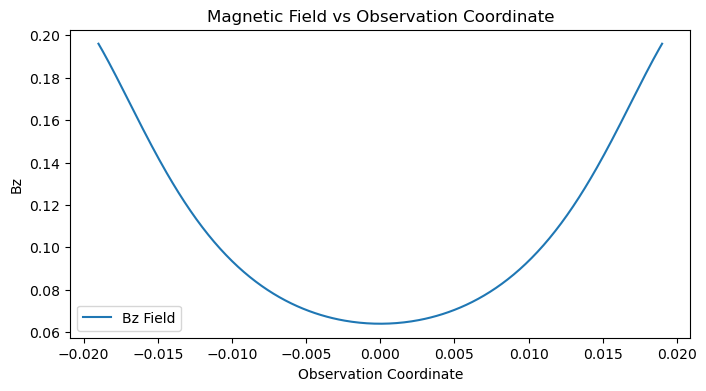

In [125]:
# Warm-up: call the adaptive function once to trigger JAX compilation.
_ = adaptive_run_field_calculation_jax(TOL)
# Run the adaptive field calculation using the tolerance defined.

start_time = time.time()
result, obs, chosen_order = adaptive_run_field_calculation_jax(TOL)
end_time = time.time()
print("Time taken for adaptive_run_field_calculation_jax: {:.4f} seconds".format(end_time - start_time))
print("Chosen Legendre polynomial order:", chosen_order)

# If the observation coordinate is along x, plot the field versus x.
if obs is not None:
    # Convert from JAX array to NumPy array for plotting
    result_np = np.array(result)
    plt.figure(figsize=(8, 4))
    plt.plot(obs, result_np, label="Bz Field")
    plt.xlabel("Observation Coordinate")
    plt.ylabel("Bz")
    plt.title("Magnetic Field vs Observation Coordinate")
    plt.legend()
    plt.show()


# Autograd works but slow

In [123]:
import jax
import jax.numpy as jnp
import numpy.polynomial.legendre as lg

# --- 1. Setup functions ---

from functools import partial

def compute_centers(a_total, a_one, b_total, b_one):
    x_centers = jnp.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, N_X)
    y_centers = jnp.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, N_Y)
    return x_centers, y_centers


@jax.jit
def setup_integration_with_x(X_val, Y_val, Z_val, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y):
    XCENTERS, YCENTERS = compute_centers(A_TOTAL, A_ONE, B_TOTAL, B_ONE)
    X_MINS = XCENTERS - A_ONE / 2.0
    X_MAXS = XCENTERS + A_ONE / 2.0
    Y_MINS = YCENTERS - B_ONE / 2.0
    Y_MAXS = YCENTERS + B_ONE / 2.0
    x_arr, y_arr, z_arr = jnp.broadcast_arrays(jnp.atleast_1d(X_val), jnp.atleast_1d(Y_val), jnp.atleast_1d(Z_val))
    x_flat = x_arr.ravel()
    y_flat = y_arr.ravel()
    z_flat = z_arr.ravel()
    return X_MINS, X_MAXS, Y_MINS, Y_MAXS, x_flat, y_flat, z_flat, x_arr.shape

def precompute_leggauss(orders):
    nodes_dict = {}
    weights_dict = {}
    for order in orders:
        nodes_np, weights_np = lg.leggauss(order)
        nodes_dict[order] = jnp.array(nodes_np)
        weights_dict[order] = jnp.array(weights_np)
    return nodes_dict, weights_dict

# --- 2. Magnetic field functions ---

@jax.jit
def dBz_jax(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx * sx + sy * sy + sz * sz
    return sz / (jnp.sqrt(s) * s)

def gauss2d_jax(func, a, b, c, d, nodes, weights, x_param, y_param, z_param):
    half_b_a = 0.5 * (b - a)
    mid_b_a  = 0.5 * (b + a)
    half_d_c = 0.5 * (d - c)
    mid_d_c  = 0.5 * (d + c)
    xs = half_b_a * nodes + mid_b_a
    ys = half_d_c * nodes + mid_d_c
    f_vals = jax.vmap(lambda xi: jax.vmap(lambda yj: func(xi, yj, x_param, y_param, z_param))(ys))(xs)
    weight_product = jnp.outer(weights, weights)
    I = jnp.sum(weight_product * f_vals)
    return I * 0.25 * (b - a) * (d - c)

@jax.jit
def Bsquare_strip_jax(x, y, z, x_min, x_max, y_min, y_max, nodes, weights):
    Bz = gauss2d_jax(dBz_jax, x_min, x_max, y_min, y_max, nodes, weights, x, y, z)
    return (1.0 / (4.0 * jnp.pi)) * Bz

@jax.jit
def Bz_one_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, mz, nodes, weights):
    Bf = Bsquare_strip_jax(x, y, z - h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    Bb = Bsquare_strip_jax(x, y, z + h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    return mz * (Bf - Bb)

@jax.jit
def Bz_two_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz, nodes, weights):
    Bt = Bz_one_magnet_jax(x, y, z - (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    Bb = Bz_one_magnet_jax(x, y, z + (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    return Bt + Bb

@jax.jit
def compute_field_at_point(x, y, z, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights):
    def col_sum(k):
        row_vals = jax.vmap(lambda j: Bz_two_magnet_jax(
            x, y, z, X_MINS[k], X_MAXS[k], Y_MINS[j], Y_MAXS[j], h, zl[k], mz, nodes, weights
        ))(jnp.arange(Y_MINS.shape[0]))
        return jnp.sum(row_vals)
    return jnp.sum(jax.vmap(col_sum)(jnp.arange(X_MINS.shape[0])))

@jax.jit
def compute_all_Bz_for_points_jax(x_obs, y_obs, z_obs, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights):
    return jax.vmap(lambda x, y, z: compute_field_at_point(
        x, y, z, X_MINS, X_MAXS, Y_MINS, Y_MAXS, zl, h, mz, nodes, weights
    ))(x_obs, y_obs, z_obs)

# --- 3. Execution ---

def run_field_calculation_jax(order, precomputed_params, nodes_dict, weights_dict, ZL, H, MZ):
    X_MINS, X_MAXS, Y_MINS, Y_MAXS, x_flat, y_flat, z_flat, _ = precomputed_params
    nodes = nodes_dict[order]
    weights = weights_dict[order]
    result = compute_all_Bz_for_points_jax(x_flat, y_flat, z_flat, X_MINS, X_MAXS, Y_MINS, Y_MAXS, ZL, H, MZ, nodes, weights)
    return result

def adaptive_run_field_calculation_jax_with_x(X_val, Y_VAL, Z_VAL, ZL, H, MZ, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y, tol, orders=[2,4,6,8,10,12,14,16,18,20]):
    precomputed_params = setup_integration_with_x(X_val, Y_VAL, Z_VAL, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y)
    nodes_dict, weights_dict = precompute_leggauss(orders)
    prev_result = None
    for order in orders:
        result = run_field_calculation_jax(order, precomputed_params, nodes_dict, weights_dict, ZL, H, MZ)
        if prev_result is not None:
            diff = jnp.max(jnp.abs(result - prev_result))
            if diff < tol:
                return result
        prev_result = result
    return result

# --- Example: gradient at a single x-coordinate ---

def loss_fn(x_single):
    # Define single observation point as a 1D array for compatibility
    result = adaptive_run_field_calculation_jax_with_x(
        jnp.array([x_single]), Y_VAL=jnp.array([0.0]), Z_VAL=jnp.array([0.0]), 
        ZL=ZL, H=H, MZ=MZ, A_TOTAL=A_TOTAL, A_ONE=A_ONE, N_X=N_X, 
        B_TOTAL=B_TOTAL, B_ONE=B_ONE, N_Y=N_Y, tol=1e-5
    )
    return jnp.sum(result)

import time

grad_loss_fn = jax.grad(loss_fn)
x0 = 0.03  # example x-coordinate
x1 = 0.04  # example x-coordinate

start_time = time.time()
grad_at_x0 = grad_loss_fn(x0)  # ensure timing includes execution
grad_at_x1 = grad_loss_fn(x1)  # ensure timing includes execution
end_time = time.time()

print(f"Computation time: {end_time - start_time:.6f} seconds")
print("Gradient at x =", x0, "is", grad_at_x0)
print("Gradient at x =", x1, "is", grad_at_x1)


Computation time: 2.002710 seconds
Gradient at x = 0.03 is -1.5472789
Gradient at x = 0.04 is -2.6629915


Time taken for adaptive_run_field_calculation_jax: 0.0341 seconds
Chosen Legendre polynomial order: 6


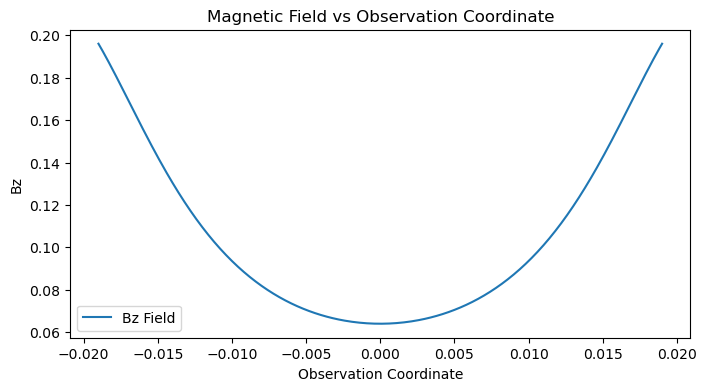

In [113]:
# Warm-up: call the adaptive function once to trigger JAX compilation.
_ = adaptive_run_field_calculation_jax_with_x(X_VAL, Y_VAL, Z_VAL, ZL, H, MZ, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y, TOL)
# Run the adaptive field calculation using the tolerance defined.

start_time = time.time()
result = adaptive_run_field_calculation_jax_with_x(X_VAL, Y_VAL, Z_VAL, ZL, H, MZ, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y, TOL)
end_time = time.time()
print("Time taken for adaptive_run_field_calculation_jax: {:.4f} seconds".format(end_time - start_time))
print("Chosen Legendre polynomial order:", chosen_order)

# If the observation coordinate is along x, plot the field versus x.
if obs is not None:
    # Convert from JAX array to NumPy array for plotting
    result_np = np.array(result)
    plt.figure(figsize=(8, 4))
    plt.plot(obs, result_np, label="Bz Field")
    plt.xlabel("Observation Coordinate")
    plt.ylabel("Bz")
    plt.title("Magnetic Field vs Observation Coordinate")
    plt.legend()
    plt.show()

# Sunday

In [2]:
import jax
import jax.numpy as jnp
from jax import jit, vmap
import numpy as np
import numpy.polynomial.legendre as lg  # for leggauss
TOL = 1e-5
ORDERS=jnp.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

In [12]:
import time
import jax.numpy as jnp
from jax import jit, vmap
import numpy.polynomial.legendre as lg

#------------------------------------------------------------------
# compute_centers: Computes the centers of the magnets.
#------------------------------------------------------------------
def compute_centers(a_total, a_one, n_x, b_total, b_one, n_y):
    x_centers = jnp.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = jnp.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    return x_centers, y_centers

#------------------------------------------------------------------
# dBz_jax: Inverse cube law for Bz field from a point dipole.
#------------------------------------------------------------------
@jit
def dBz_jax(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx * sx + sy * sy + sz * sz
    return sz / (jnp.sqrt(s) * s)

#------------------------------------------------------------------
# gauss2d_jax: Performs 2D Gauss–Legendre quadrature over a rectangle.
# Uses nested vmaps to evaluate the integrand on the quadrature grid.
#------------------------------------------------------------------
def gauss2d_jax(func, a, b, c, d, nodes, weights, x_param, y_param, z_param):
    half_b_a = 0.5 * (b - a)
    mid_b_a  = 0.5 * (b + a)
    half_d_c = 0.5 * (d - c)
    mid_d_c  = 0.5 * (d + c)
    # Quadrature points along x and y:
    xi = half_b_a * nodes + mid_b_a
    yj = half_d_c * nodes + mid_d_c
    # Evaluate the integrand over the grid using nested vmap:
    f_val = vmap(lambda x: vmap(lambda y: func(x, y, x_param, y_param, z_param))(yj))(xi)
    I = jnp.sum(weights[:, None] * weights[None, :] * f_val)
    I *= 0.25 * (b - a) * (d - c)
    return I

#------------------------------------------------------------------
# Bsquare_strip_jax: Computes the Bz field from one half (strip) of a magnet.
#------------------------------------------------------------------
@jit
def Bsquare_strip_jax(x, y, z, x_min, x_max, y_min, y_max, nodes, weights):
    Bz = gauss2d_jax(dBz_jax, x_min, x_max, y_min, y_max, nodes, weights, x, y, z)
    C = 1.0 / (4.0 * jnp.pi)
    return C * Bz

#------------------------------------------------------------------
# Bz_one_magnet_jax: Computes net z-field for one magnet (difference of two halves).
#------------------------------------------------------------------
@jit
def Bz_one_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, mz, nodes, weights):
    Bf = Bsquare_strip_jax(x, y, z - h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    Bb = Bsquare_strip_jax(x, y, z + h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    return mz * (Bf - Bb)

#------------------------------------------------------------------
# Bz_two_magnet_jax: Computes net field from two magnets.
#------------------------------------------------------------------
@jit
def Bz_two_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz, nodes, weights):
    Bt = Bz_one_magnet_jax(x, y, z - (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    Bb = Bz_one_magnet_jax(x, y, z + (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    return Bt + Bb

#------------------------------------------------------------------
# bfld: Simplified (adaptive, symmetric) field calculator.
# Computes the Bz field at observation points along one coordinate axis.
#
# This version loops over the magnet columns to handle ZL correctly.
#------------------------------------------------------------------
def bfld(tol, orders, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y, obs, H, ZL, MZ, direction='z'):
    # Return the full (x,y,z) coordinates for an observation point along the chosen axis.
    def obs_point(pt):
        if direction == 'x':
            return pt, 0.0, 0.0
        elif direction == 'y':
            return 0.0, pt, 0.0
        elif direction == 'z':
            return 0.0, 0.0, pt
        else:
            raise ValueError("direction must be 'x', 'y', or 'z'")
    
    # Compute magnet centers and boundaries.
    XC, YC = compute_centers(A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y)
    X_MIN = XC - A_ONE/2.0
    X_MAX = XC + A_ONE/2.0
    Y_MIN = YC - B_ONE/2.0
    Y_MAX = YC + B_ONE/2.0
    # Create magnet grid.
    X_MIN_grid, Y_MIN_grid = jnp.meshgrid(X_MIN, Y_MIN, indexing="ij")
    X_MAX_grid, Y_MAX_grid = jnp.meshgrid(X_MAX, Y_MAX, indexing="ij")
    
    prev_field = None
    chosen_order = orders[-1]
    # Convert orders to a Python list of ints.
    for order in orders.tolist():
        nodes_np, weights_np = lg.leggauss(int(order))
        nodes = jnp.array(nodes_np)
        weights = jnp.array(weights_np)
        
        def field_at_obs(pt):
            x_pt, y_pt, z_pt = obs_point(pt)
            # For each magnet, sum contributions.
            def magnet_contrib(xmin, xmax, ymin, ymax, zl):
                return Bz_two_magnet_jax(x_pt, y_pt, z_pt, xmin, xmax, ymin, ymax,
                                         H, zl, MZ, nodes, weights)
            # Vectorize over the magnet columns (x-direction) for a given column index.
            vmapped_over_cols = vmap(magnet_contrib, in_axes=(0, 0, 0, 0, 0))
            # Loop over the second (y) dimension; for each column, use the corresponding ZL.
            contribs = jnp.stack([
                vmapped_over_cols(X_MIN_grid[:, j],
                                  X_MAX_grid[:, j],
                                  Y_MIN_grid[:, j],
                                  Y_MAX_grid[:, j],
                                  ZL)
                for j in range(Y_MIN_grid.shape[1])
            ], axis=1)
            return jnp.sum(contribs)
        
        field_vals = jnp.vectorize(field_at_obs)(obs)
        
        if prev_field is not None:
            diff = jnp.max(jnp.abs(field_vals - prev_field))
            if diff < tol:
                chosen_order = order
                break
        prev_field = field_vals

    # Exploit symmetry: assume obs is symmetric about zero.
    pos_mask = obs >= 0
    obs_pos = obs[pos_mask]
    field_pos = field_vals[pos_mask]
    if jnp.isclose(obs_pos[0], 0.0):
        field_neg = jnp.flip(field_pos[1:])
        obs_neg = -jnp.flip(obs_pos[1:])
    else:
        field_neg = jnp.flip(field_pos)
        obs_neg = -jnp.flip(obs_pos)
    full_field = jnp.concatenate([field_neg, field_pos])
    full_obs = jnp.concatenate([obs_neg, obs_pos])
    
    return full_field, full_obs, chosen_order

In [19]:
#------------------------------------------------------------------
# Starting parameters.
#------------------------------------------------------------------
A_TOTAL = 80e-3    # Total grid width in x
A_ONE   = 8e-3     # Width of each magnet in x
N_X     = 10      # Number of magnets in x-direction
B_TOTAL = 18e-3    # Total grid depth in y
B_ONE   = 1e-3     # Depth of each magnet in y
N_Y     = 18       # Number of magnets in y-direction
H       = 5e-3     # Height of each magnet (z)
MZ      = 1.19     # Magnetization in z

# ZL: offset for each magnet column (length N_X).
ZL = jnp.array([20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3])

# Observation points (assuming symmetry along z).
# (X_VAL and Y_VAL are single values; only Z_VAL is an array.)
X_VAL = 0.0        
Y_VAL = 0.0        
Z_VAL = jnp.arange(-40e-3, 41e-3, 1e-3)  # Array of z-values, symmetric about 0

# Tolerance and Legendre orders.
TOL = 1e-5
ORDERS = jnp.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

#------------------------------------------------------------------
# Time the function execution and print the results.
#------------------------------------------------------------------
start_time = time.time()
full_field, full_obs, chosen_order = bfld(TOL, ORDERS, A_TOTAL, A_ONE, N_X,
                                            B_TOTAL, B_ONE, N_Y,
                                            Z_VAL, H, ZL, MZ, direction='x')
end_time = time.time()

print("Full field:", full_field)
print("Observation points:", full_obs)
print("Chosen Legendre order:", chosen_order)
print("Elapsed time: {:.4f} seconds".format(end_time - start_time))

Full field: [0.03039525 0.03305337 0.03568115 0.03824903 0.04073002 0.04310074
 0.04534208 0.04743972 0.04938402 0.05116987 0.05279627 0.05426573
 0.05558359 0.05675739 0.05779618 0.05871005 0.05950954 0.06020532
 0.06080788 0.06132722 0.06177286 0.06215352 0.06247732 0.06275154
 0.06298277 0.06317691 0.06333912 0.06347407 0.06358577 0.06367773
 0.06375296 0.06381416 0.06386357 0.0639031  0.06393433 0.06395864
 0.06397713 0.06399064 0.06399982 0.06400517 0.06400517 0.06399982
 0.06399064 0.06397713 0.06395864 0.06393433 0.0639031  0.06386357
 0.06381416 0.06375296 0.06367773 0.06358577 0.06347407 0.06333912
 0.06317691 0.06298277 0.06275154 0.06247732 0.06215352 0.06177286
 0.06132722 0.06080788 0.06020532 0.05950954 0.05871005 0.05779618
 0.05675739 0.05558359 0.05426573 0.05279627 0.05116987 0.04938402
 0.04743972 0.04534208 0.04310074 0.04073002 0.03824903 0.03568115
 0.03305337 0.03039525]
Observation points: [-0.03999986 -0.03899986 -0.03799987 -0.03699987 -0.03599987 -0.03499987


In [30]:
#------------------------------------------------------------------
# compute_centers: Computes the centers of the magnets.
#------------------------------------------------------------------
def compute_centers(a_total, a_one, n_x, b_total, b_one, n_y):
    x_centers = jnp.linspace(-a_total/2 + a_one/2, a_total/2 - a_one/2, n_x)
    y_centers = jnp.linspace(-b_total/2 + b_one/2, b_total/2 - b_one/2, n_y)
    return x_centers, y_centers

#------------------------------------------------------------------
# dBz_jax: Inverse cube law for Bz field from a point dipole.
#------------------------------------------------------------------
@jit
def dBz_jax(xp, yp, x, y, z):
    sx = x - xp
    sy = y - yp
    sz = z
    s = sx * sx + sy * sy + sz * sz
    return sz / (jnp.sqrt(s) * s)

#------------------------------------------------------------------
# gauss2d_jax: Performs 2D Gauss–Legendre quadrature over a rectangle.
# Uses nested vmaps to evaluate the integrand on the quadrature grid.
#------------------------------------------------------------------
def gauss2d_jax(func, a, b, c, d, nodes, weights, x_param, y_param, z_param):
    half_b_a = 0.5 * (b - a)
    mid_b_a  = 0.5 * (b + a)
    half_d_c = 0.5 * (d - c)
    mid_d_c  = 0.5 * (d + c)
    # Quadrature points along x and y:
    xi = half_b_a * nodes + mid_b_a
    yj = half_d_c * nodes + mid_d_c
    # Evaluate the integrand over the grid using nested vmap:
    f_val = vmap(lambda x: vmap(lambda y: func(x, y, x_param, y_param, z_param))(yj))(xi)
    I = jnp.sum(weights[:, None] * weights[None, :] * f_val)
    I *= 0.25 * (b - a) * (d - c)
    return I

#------------------------------------------------------------------
# Bsquare_strip_jax: Computes the Bz field from one half (strip) of a magnet.
#------------------------------------------------------------------
@jit
def Bsquare_strip_jax(x, y, z, x_min, x_max, y_min, y_max, nodes, weights):
    Bz = gauss2d_jax(dBz_jax, x_min, x_max, y_min, y_max, nodes, weights, x, y, z)
    C = 1.0 / (4.0 * jnp.pi)
    return C * Bz

#------------------------------------------------------------------
# Bz_one_magnet_jax: Computes net z-field for one magnet (difference of two halves).
#------------------------------------------------------------------
@jit
def Bz_one_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, mz, nodes, weights):
    Bf = Bsquare_strip_jax(x, y, z - h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    Bb = Bsquare_strip_jax(x, y, z + h/2.0, x_min, x_max, y_min, y_max, nodes, weights)
    return mz * (Bf - Bb)

#------------------------------------------------------------------
# Bz_two_magnet_jax: Computes net field from two magnets.
#------------------------------------------------------------------
@jit
def Bz_two_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, h, zl, mz, nodes, weights):
    Bt = Bz_one_magnet_jax(x, y, z - (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    Bb = Bz_one_magnet_jax(x, y, z + (zl + h/2.0), x_min, x_max, y_min, y_max, h, mz, nodes, weights)
    return Bt + Bb

#------------------------------------------------------------------
# run_field_calculation_jax:
# Computes the magnetic field at observation points (without symmetry).
#------------------------------------------------------------------
def run_field_calculation_jax(order, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y,
                              X_VAL, Y_VAL, Z_VAL, H, ZL, MZ):
    order = int(order)
    XCENTERS, YCENTERS = compute_centers(A_TOTAL, A_ONE, B_TOTAL, B_ONE)
    X_MINS = XCENTERS - A_ONE/2.0
    X_MAXS = XCENTERS + A_ONE/2.0
    Y_MINS = YCENTERS - B_ONE/2.0
    Y_MAXS = YCENTERS + B_ONE/2.0
    nodes_np, weights_np = lg.leggauss(order)
    nodes = jnp.array(nodes_np)
    weights = jnp.array(weights_np)
    x_arr, y_arr, z_arr = jnp.broadcast_arrays(jnp.atleast_1d(X_VAL),
                                               jnp.atleast_1d(Y_VAL),
                                               jnp.atleast_1d(Z_VAL))
    x_flat = x_arr.ravel()
    y_flat = y_arr.ravel()
    z_flat = z_arr.ravel()
    X_MIN_grid, Y_MIN_grid = jnp.meshgrid(X_MINS, Y_MINS, indexing="ij")
    X_MAX_grid, Y_MAX_grid = jnp.meshgrid(X_MAXS, Y_MAXS, indexing="ij")
    
    def field_at_point(x, y, z):
        def magnet_contrib(x_min, x_max, y_min, y_max, zl):
            return Bz_two_magnet_jax(x, y, z, x_min, x_max, y_min, y_max, H, zl, MZ, nodes, weights)
        # Here we vectorize over columns, then stack rows via a list comprehension.
        vmapped_over_cols = vmap(magnet_contrib, in_axes=(0, 0, 0, 0, 0))
        contribs = jnp.stack([vmapped_over_cols(X_MIN_grid[:, j],
                                                X_MAX_grid[:, j],
                                                Y_MIN_grid[:, j],
                                                Y_MAX_grid[:, j],
                                                ZL)
                              for j in range(Y_MIN_grid.shape[1])], axis=1)
        return jnp.sum(contribs)
    
    field_at_point_vec = vmap(field_at_point)
    result_flat = field_at_point_vec(x_flat, y_flat, z_flat)
    result = result_flat.reshape(x_arr.shape)
    
    X_arr_check = jnp.atleast_1d(X_VAL)
    Y_arr_check = jnp.atleast_1d(Y_VAL)
    Z_arr_check = jnp.atleast_1d(Z_VAL)
    if X_arr_check.size > 1:
        obs = X_arr_check
    elif Y_arr_check.size > 1:
        obs = Y_arr_check
    elif Z_arr_check.size > 1:
        obs = Z_arr_check
    else:
        obs = None
    return result, obs

#------------------------------------------------------------------
# adaptive_run_field_calculation_jax:
# Automatically finds the optimal Legendre order for the given tolerance.
#------------------------------------------------------------------
def adaptive_run_field_calculation_jax(tol, orders, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y,
                                       X_VAL, Y_VAL, Z_VAL, H, ZL, MZ):
    prev_result = None
    for order in orders:
        result, obs = run_field_calculation_jax(order, A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y,
                                                 X_VAL, Y_VAL, Z_VAL, H, ZL, MZ)
        if prev_result is not None:
            diff = jnp.max(jnp.abs(result - prev_result))
            if diff < tol:
                return result, obs, order
        prev_result = result
    print("No convergence reached; using order", orders[-1])
    return result, obs, orders[-1]

#------------------------------------------------------------------
# adaptive_run_field_calculation_symmetric_jax:
# Exploits symmetry: computes the adaptive field on the nonnegative side,
# then mirrors the result to cover the full observation domain.
#------------------------------------------------------------------
def adaptive_run_field_calculation_symmetric_jax(tol, orders,
                                                 A_TOTAL, A_ONE, N_X,
                                                 B_TOTAL, B_ONE, N_Y,
                                                 X_VAL, Y_VAL, Z_VAL,
                                                 H, ZL, MZ):
    Z_VAL = jnp.atleast_1d(Z_VAL)
    pos_mask = Z_VAL >= 0
    Z_pos = Z_VAL[pos_mask]
    result_pos, obs_pos, chosen_order = adaptive_run_field_calculation_jax(
        tol,
        orders,
        A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y,
        X_VAL, Y_VAL, Z_pos, H, ZL, MZ
    )
    if jnp.isclose(obs_pos[0], 0.0):
        result_neg = jnp.flip(result_pos[1:], axis=0)
        obs_neg = -jnp.flip(obs_pos[1:], axis=0)
    else:
        result_neg = jnp.flip(result_pos, axis=0)
        obs_neg = -jnp.flip(obs_pos, axis=0)
    full_result = jnp.concatenate([result_neg, result_pos], axis=0)
    full_obs = jnp.concatenate([obs_neg, obs_pos], axis=0)
    return full_result, full_obs, chosen_order

NameError: name 'jit' is not defined

In [21]:
#==================================================================
# Example Usage:
#==================================================================

# Define grid and magnet parameters.
A_TOTAL = 80e-3    # Total grid width in x
A_ONE   = 8e-3   # Width of each magnet in x
N_X     = 10      # Number of magnets in x-direction
B_TOTAL = 18e-3    # Total grid depth in y
B_ONE   = 1e-3     # Depth of each magnet in y
N_Y     = 18       # Number of magnets in y-direction
H       = 5e-3     # Height of each magnet (z)
MZ      = 1.19     # Magnetization in z

# ZL: offset for each magnet column (length N_X).
ZL = jnp.array([15e-3, 20e-3, 15e-3, 20e-3, 20e-3, 20e-3, 20e-3, 15e-3, 20e-3, 15e-3])
# jnp.array([20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3, 20e-3]) --- jnp.full((N_X,), 20e-3)

# Observation points (assuming symmetry along z).
X_VAL = 0.0         # Single x-coordinate (will be broadcast)
Y_VAL = 0.0         # Single y-coordinate (will be broadcast)
Z_VAL = jnp.arange(-19e-3, 20e-3, 1e-3)  # Array of z-values, symmetric about 0

# Tolerance and Legendre orders.
TOL = 1e-5
ORDERS = jnp.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

# Warm-up the adaptive function (to trigger compilation).
_ = adaptive_run_field_calculation_symmetric_jax(TOL, ORDERS,
    A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y,
    X_VAL, Y_VAL, Z_VAL, H, ZL, MZ)

In [22]:
import time

# Time the adaptive symmetric routine.
start_time = time.perf_counter()
full_result, full_obs, chosen_order = adaptive_run_field_calculation_symmetric_jax(
    TOL, ORDERS,
    A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y,
    X_VAL, Y_VAL, Z_VAL, H, ZL, MZ
)
end_time = time.perf_counter()

print("Adaptive symmetric routine runtime: {:.6f} seconds".format(end_time - start_time))
print("Chosen Legendre Order:", chosen_order)
print("Full field result shape:", full_result)


Adaptive symmetric routine runtime: 0.235837 seconds
Chosen Legendre Order: 14
Full field result shape: [0.19458315 0.18010546 0.16488855 0.14986876 0.13572328 0.12286789
 0.11149897 0.10165253 0.09326085 0.08619843 0.08031548 0.07545961
 0.07148906 0.06827909 0.06572503 0.06374187 0.06226356 0.06124096
 0.06064046 0.06044245 0.06064046 0.06124096 0.06226356 0.06374187
 0.06572503 0.06827909 0.07148906 0.07545961 0.08031548 0.08619843
 0.09326085 0.10165253 0.11149897 0.12286789 0.13572328 0.14986876
 0.16488855 0.18010546 0.19458315]


In [26]:
#==================================================================
# Vectorized Computation Over Scale Factors (Fixed Adaptive Order)
#==================================================================

if __name__ == '__main__':
    # Define grid and magnet parameters.
    A_TOTAL = 80e-3    # Total grid width in x
    A_ONE   = 0.8e-3   # Magnet width in x
    N_X     = 100      # Number of magnets in x-direction
    B_TOTAL = 18e-3    # Total grid depth in y
    B_ONE   = 1e-3     # Magnet depth in y
    N_Y     = 18       # Number of magnets in y-direction
    H       = 5e-3     # Magnet height in z
    MZ      = 1.19     # Magnetization in z

    base_ZL = 20e-3   # Base ZL value
    # For this test, we'll assume a fixed observation point set.
    # Here, we use a high-resolution range in x (symmetric about 0) for demonstration.
    X_VAL = jnp.arange(-40e-3, 40.1e-3, 1e-4)
    Y_VAL = 0.0
    # For simplicity, we fix Z_VAL to a single value (e.g., 0.0) since our symmetric routine mirrors along z.
    Z_VAL = jnp.array([0.0])
    
    TOL = 1e-5
    ORDERS = jnp.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
    
    # First, run the adaptive symmetric routine for one instance to determine the chosen Legendre order.
    ZL_instance = jnp.full((N_X,), base_ZL)
    _, _, chosen_order = adaptive_run_field_calculation_symmetric_jax(TOL, ORDERS,
                                                    A_TOTAL, A_ONE, N_X,
                                                    B_TOTAL, B_ONE, N_Y,
                                                    X_VAL, Y_VAL, Z_VAL,
                                                    H, ZL_instance, MZ)
    print("Chosen Legendre Order for all instances:", chosen_order)
    
    # Define a function that, given a scale factor, builds the corresponding ZL array and computes the field.
    # We use the fixed chosen_order obtained above.
    def compute_field_for_scale(scale):
        ZL_inst = jnp.full((N_X,), scale * base_ZL)
        # Here we use run_field_calculation_jax (non-adaptive) with the fixed chosen_order.
        result, obs = run_field_calculation_jax(chosen_order, A_TOTAL, A_ONE, N_X,
                                                 B_TOTAL, B_ONE, N_Y,
                                                 X_VAL, Y_VAL, Z_VAL, H,
                                                 ZL_inst, MZ)
        # (Optionally, you could use the symmetric version if applicable.)
        return result, obs

    # Vectorize the computation over scales.
    # This replaces the Python loop.
    vmap_compute_field = jax.vmap(lambda scale: compute_field_for_scale(scale))
    
    # Create 1000 scale factors between 0.5 and 1.5.
    scales = jnp.linspace(0.5, 1.5, 100)
    
    overall_start = time.perf_counter()
    results, obs_results = vmap_compute_field(scales)
    overall_end = time.perf_counter()
    total_runtime = overall_end - overall_start
    print(f"\nTotal runtime for 1000 scale instances (vectorized): {total_runtime:.6f} seconds")

Chosen Legendre Order for all instances: 4

Total runtime for 1000 scale instances (vectorized): 1.430182 seconds


In [109]:
_ = adaptive_run_field_calculation_symmetric_jax(TOL, ORDERS,
                A_TOTAL, A_ONE, N_X, B_TOTAL, B_ONE, N_Y,
                X_VAL, Y_VAL, Z_VAL, H, ZL_instance, MZ)